Метод из оригинальной статьи

Balanced difficulty task finder: an adaptive recommendation method for learning tasks based on the concept of state of flow
$$
    \min(0,\max(1,))
$$
https://pubmed.ncbi.nlm.nih.gov/33014180/

Polyak–Ruppert averaging

Полученные коэффицеинты подставляемые в функцию отклика $\theta_k = \frac{1}{k} \sum^{k-1}_j=0 \theta_j$

In [15]:
class Monkey:
    def __init__(self,name):
        self.name = name
    def say(self):
        return 'meow'
    
class CleverMonkey(Monkey):
    def hi(self):
        return '1' + self.say()

CleverMonkey(name='san').hi()

'1meow'

In [17]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from enum import Enum
import numpy as np
import typing as tp 
import abc

In [196]:
def running_mean(array,skip:int = 20,window:int = 200):
    result = np.zeros(len(array))
    cumulative_sum  = np.cumsum(array)
    result[:skip] = np.NaN
    result[skip:window] = cumulative_sum[skip:window] / (np.arange(window)[skip:]+1)
    result[window:] = (cumulative_sum[window:] - cumulative_sum[:-window]) / window
    return result

In [197]:
class AbstractUpdateRule:
    '''
    Марковское правило обновления 
    @player_level:  Уровень игрока float[0,1]
    @dispersion: Ошибка наблюдения float[0,\infty]
    @response_rate: Скорость реакции float[0,\infty]
    '''
    def __init__(self,response_rate: float,optimal_try_rate:float):
        pass
        
    @abc.abstractmethod
    def __call__(self,difficulty: float, result: int):
        pass

    def clear(self):
        pass

class RobinsUpdateRule(AbstractUpdateRule):
    def __init__(self,response_rate: float, optimal_try_rate: float ):
        self.response_rate = response_rate
        self.counter = 0
        self.optimal_try_rate = optimal_try_rate
        self.response_rate = response_rate

    def __call__(self,difficulty: float, result: int):
        self.counter += 1
        return difficulty - self.response_rate / self.counter * ( self.optimal_try_rate - result)


class FilterRobinsUpdateRule(AbstractUpdateRule):
    '''
    Вносятся ограничения на сложность
    '''
    def __call__(self,difficulty: float, result: int):
        return max(1,min(0,super()(difficulty)))
    

class PolyakUpdateRule(RobinsUpdateRule):
    '''
    Использование метода Поляка для усреднения последних итераций
    '''
    def __init__(self,  response_rate: float, optimal_try_rate: float, cut_window: int = 0):
        self.storage = []
        self.cut_window = cut_window
        super.__init__(response_rate, optimal_try_rate)

    @abc.abstractmethod
    def __call__(self,difficulty: float, result: int):
        self.storage.append(super()(difficulty))
        return sum(self.storage[-self.cut_window:]) / (self.counter - self.cut_window)
    
    def clear(self):
        self.storage=[]

In [195]:
class ResponseFunction:
    def __init__(self, response_function: tp.Callable[[float],float]):
        self.response_function = response_function
             
    def __call__(self, difficulty: float):
        return int(self.response_function(difficulty) > random.random())

In [256]:
from contextlib import contextmanager

class History:
    def __init__(self):
        self.storage = []

    @contextmanager
    def new_log(self):
        new_log = []
        yield new_log
        self.storage.append(new_log)
    
    def sample_trajectories():
        running_mean()

    def results(self):
        array = np.array(self.storage)
        return np.mean(array[:,:,0],axis=0) , np.mean(array[:,:,1],axis=0)


class Plotter:

   def __init__(self,title: str):
        '''
        @title: Название эксперимента
        '''
        self.title = title

   def plot(self,history: History):
        mean_difficulty, mean_efficiency = history.results()
        fig,ax = plt.subplots(1,2,figsize=(20,10))
        fig.suptitle(self.title)       
        ax[0].plot(mean_difficulty,label='Сложность задания')
        ax[1].set(title='')
        #plt.hlines()
        ax[1].plot(mean_efficiency,label='Сложность задания')
        ax[1].set(title='')
        ax[0].legend()
        ax[0].grid()


class Test:
    def __init__(self, 
        initial_difficulty: float,
        rounds: int,
        tries:int,
        response_function: ResponseFunction,
        update_rule: AbstractUpdateRule
    ):
        '''
        Инициализирует тест
        @rounds: число раундов проведения тестирования
        @tries: число повтора эксперимента для усреднения
        @init_difficulty: Начальный уровень сложности float[0,1]
 
        '''

        self.response_function = response_function
        self.update_rule = update_rule
        self.initial_difficulty = initial_difficulty
        self.round_number = rounds
        self.tries= tries
        self.history = History()

    def perform(self):
        '''
        Число тестов
        '''
        for _ in tqdm(range(self.tries)):
            difficulty = self.initial_difficulty
            with self.history.new_log() as log: 
                for __ in range(self.round_number):
                    difficulty, result = self.round(difficulty)
                    log.append([difficulty, result])
        return self

    def round(self, previous_difficulty: int):
        self.result = self.response_function(previous_difficulty)
        self.difficulty = self.update_rule(previous_difficulty,self.result)
        return  self.difficulty,self.result



In [245]:
def elo(player_level:float =0.4,dispersion:float=0.2):
    '''
    Возвращает параметризованную функцию Эло
    @player_level: Уровень игрока float[0,1]
    @dispersion: Ошибка наблюдения float[0,\infty]
    '''
    return lambda d: 1 - 1/(1 +np.exp((player_level-d)/ dispersion))

100%|██████████| 1000/1000 [00:00<00:00, 1148.61it/s]


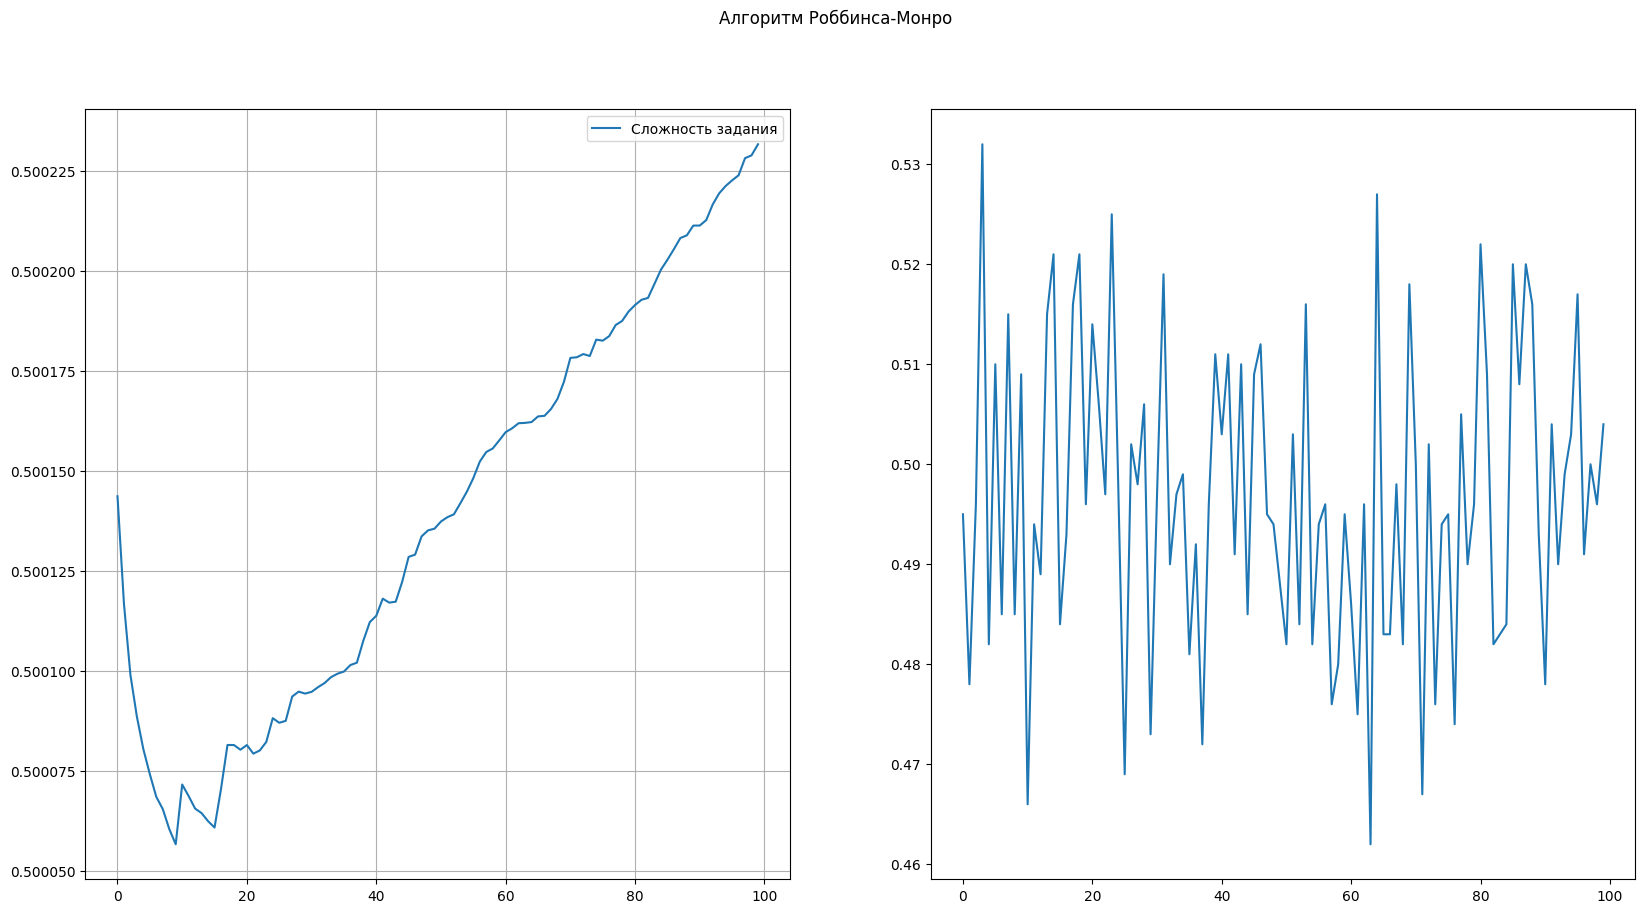

In [257]:
experiment_results = Test(
    initial_difficulty = 0.5,
    rounds=100,
    tries=1000,
    response_function = ResponseFunction(elo(
        player_level =0.5,dispersion=0.01
    )),
    update_rule=RobinsUpdateRule(
        response_rate=0.2,
        optimal_try_rate=0.3
    ),
).perform().history
Plotter('Алгоритм Роббинса-Монро',).plot(experiment_results)

In [237]:
Test(
    initial_difficulty = 0.5,
    rounds=100,
    tries=10,
    title='Алгоритм Роббинса-Монро',
    response_function = ResponseFunction(elo(
        player_level =0.5,dispersion=0.01
    )),
    update_rule=PolyakUpdateRule(
        response_rate=0.2,
        optimal_try_rate=0.3
    ),
).perform().plot()

TypeError: descriptor '__init__' requires a 'super' object but received a 'float'

In [ ]:

lambdas = [9]
s_optimal = [0.2,0.5, 0.7]
func 


plt.plot()

Модификация скользящим средним по поляку 
https://pubmed.ncbi.nlm.nih.gov/33014180/